In [2]:
import analyse
import os
import re
import importlib
import MDAnalysis as mda
import MDAnalysis.analysis.rms as rms
import MDAnalysis.analysis.hbonds
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
importlib.reload(analyse)

<module 'analyse' from '/home/bertalae93/Documents/research_project/code/analyse.py'>

In [4]:
def save_figure(fig, target):
    fig.savefig(target)

In [5]:
PDB_CODE = '4djh'
SEQ = 'A'
folder = '../'+PDB_CODE+SEQ+'/'
results_folder = folder+'results/'
plot_folder = folder+'plots/'

In [6]:
dcd_files = sorted([results_folder+'namd/'+i for i in os.listdir(results_folder+'namd/') if re.match(r'(step7.).*\_production.dcd$', i)])

In [7]:
print(dcd_files)

['../4djhA/results/namd/step7.1_production.dcd', '../4djhA/results/namd/step7.2_production.dcd', '../4djhA/results/namd/step7.3_production.dcd', '../4djhA/results/namd/step7.4_production.dcd', '../4djhA/results/namd/step7.5_production.dcd']


In [8]:
trajectory =  mda.Universe(results_folder+'step5_assembly.xplor_ext.psf', dcd_files)
ref = mda.Universe(folder+PDB_CODE+'_inp.pdb')

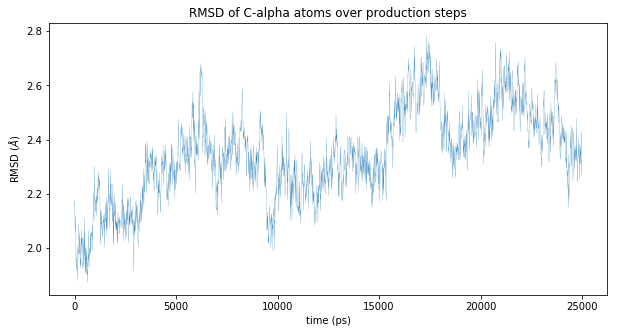

In [9]:
title = 'RMSD of C-alpha atoms over production steps'
R, r_fig = analyse.rmsd_traj(trajectory, ref, title)

In [91]:
save_figure(r_fig[0].figure, plot_folder+'prod_rmsd')

In [11]:
pdb_file = folder+PDB_CODE+'_inp.pdb'
struct = analyse.secondary_structure(pdb_file)

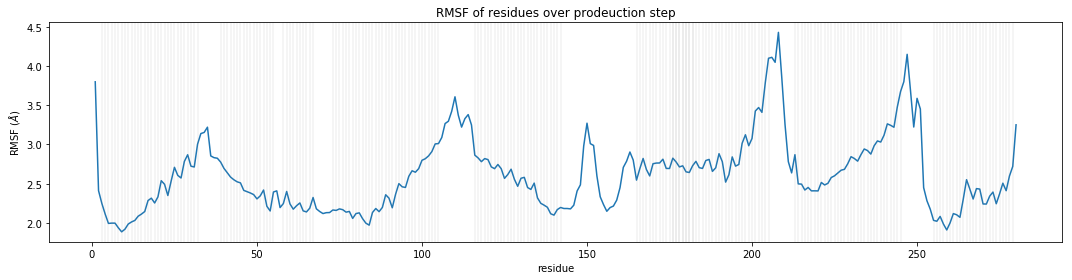

In [12]:
rmsf_fig = analyse.rmsf_plot([trajectory], title='RMSF of residues over prodeuction step', structure=struct)

In [13]:
save_figure(rmsf_fig, plot_folder+'prod_rmsf')

In [26]:
protein = ref.select_atoms('protein')
print(protein.residues.resnames)

['SER' 'PRO' 'ALA' 'ILE' 'PRO' 'VAL' 'ILE' 'ILE' 'THR' 'ALA' 'VAL' 'TYR'
 'SER' 'VAL' 'VAL' 'PHE' 'VAL' 'VAL' 'GLY' 'LEU' 'VAL' 'GLY' 'ASN' 'SER'
 'LEU' 'VAL' 'MET' 'PHE' 'VAL' 'ILE' 'ILE' 'ARG' 'TYR' 'THR' 'LYS' 'MET'
 'LYS' 'THR' 'ALA' 'THR' 'ASN' 'ILE' 'TYR' 'ILE' 'PHE' 'ASN' 'LEU' 'ALA'
 'LEU' 'ALA' 'ASP' 'ALA' 'LEU' 'VAL' 'THR' 'THR' 'THR' 'MET' 'PRO' 'PHE'
 'GLN' 'SER' 'THR' 'VAL' 'TYR' 'LEU' 'MET' 'ASN' 'SER' 'TRP' 'PRO' 'PHE'
 'GLY' 'ASP' 'VAL' 'LEU' 'CYS' 'LYS' 'ILE' 'VAL' 'LEU' 'SER' 'ILE' 'ASP'
 'TYR' 'TYR' 'ASN' 'MET' 'PHE' 'THR' 'SER' 'ILE' 'PHE' 'THR' 'LEU' 'THR'
 'MET' 'MET' 'SER' 'VAL' 'ASP' 'ARG' 'TYR' 'ILE' 'ALA' 'VAL' 'CYS' 'HIS'
 'PRO' 'VAL' 'LYS' 'ALA' 'LEU' 'ASP' 'PHE' 'ARG' 'THR' 'PRO' 'LEU' 'LYS'
 'ALA' 'LYS' 'ILE' 'ILE' 'ASN' 'ILE' 'CYS' 'ILE' 'TRP' 'LEU' 'LEU' 'SER'
 'SER' 'SER' 'VAL' 'GLY' 'ILE' 'SER' 'ALA' 'ILE' 'VAL' 'LEU' 'GLY' 'GLY'
 'THR' 'LYS' 'VAL' 'ARG' 'GLU' 'ASP' 'VAL' 'ASP' 'VAL' 'ILE' 'GLU' 'CYS'
 'SER' 'LEU' 'GLN' 'PHE' 'PRO' 'ASP' 'ASP' 'ASP' 'T

In [24]:
d = {'resId': protein.residues.resids, 'resName': protein.residues.resnames}
df = pd.DataFrame(data=d)
# print(df)

In [30]:
trp = ref.select_atoms('resid 233')
print(trp.residues)

<ResidueGroup [<Residue TRP, 233>]>


In [61]:
r = rms.RMSD(trajectory.select_atoms('name CA'),
             ref.select_atoms('name CA'), 
             select='name CA', 
             groupselections=['resname TRP and name CA and resid 233', 'resname SER and name CA']).run()

[[0.00000000e+00 1.00000000e+00 2.00000000e+00 ... 2.49700000e+03
  2.49800000e+03 2.49900000e+03]
 [0.00000000e+00 1.00000000e+01 2.00000001e+01 ... 2.49700001e+04
  2.49800001e+04 2.49900001e+04]
 [2.15554690e+00 2.17455563e+00 2.08437198e+00 ... 2.40298294e+00
  2.27025989e+00 2.32561536e+00]
 [1.27399167e+00 1.13529492e+00 1.18824521e+00 ... 2.64017179e+00
  2.78917110e+00 2.37166830e+00]
 [2.83462321e+00 2.94968075e+00 2.82703501e+00 ... 3.27596190e+00
  3.21020165e+00 3.23603577e+00]]


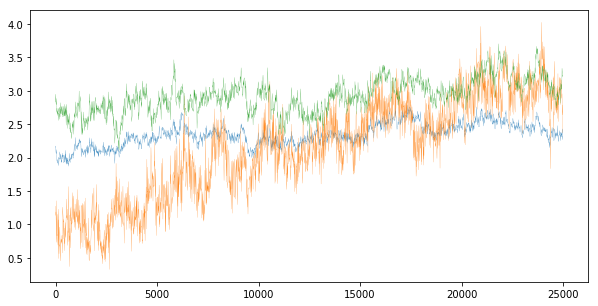

In [62]:
R = r.rmsd.T
print(R)
frame = R[0]
time = R[1]
plt.subplots(figsize=(10,5))
plt.plot(time, R[2], linewidth=0.2)
plt.plot(time, R[3], linewidth=0.2)
plt.plot(time, R[4], linewidth=0.2)
plt.show()

In [34]:
print(trajectory.select_atoms('resid 233 and ')) 

<AtomGroup [<Atom 3795: CA of type CT1 of resname TRP, resid 233 and segid PROA>]>


In [35]:
print(ref.select_atoms('resid 233 and name CA')) 

<AtomGroup [<Atom 1842: CA of type C of resname TRP, resid 233 and segid SYSTEM and altLoc >]>


## RMSF of the loops:

In [65]:
print(struct['helix'])

[  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  58  59  60  61  62  63  64
  65  66  67  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 165 166 167 168 169 170 171 172 173
 174 175 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279]


In [70]:
r = rms.RMSD(trajectory.select_atoms('name CA'),
             ref.select_atoms('name CA'), 
             select='name CA', 
             groupselections=['name CA and resid 3-32',
                              'name CA and resid 39-67',
                              'name CA and resid 73-105', 
                              'name CA and resid 116-142',
                              'name CA and resid 165-205',
                              'name CA and resid 213-245',
                              'name CA and resid 255-279']).run()

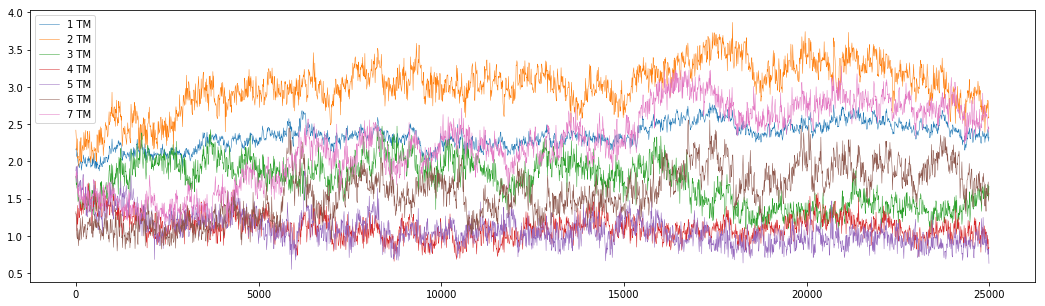

In [92]:
R = r.rmsd.T
frame = R[0]
time = R[1]
fig, ax = plt.subplots(1, figsize=(18,5))
ax.plot(time, R[2], linewidth=0.5, label='1 TM')
ax.plot(time, R[3], linewidth=0.5, label='2 TM')
ax.plot(time, R[4], linewidth=0.5, label='3 TM')
ax.plot(time, R[5], linewidth=0.5, label='4 TM')
ax.plot(time, R[6], linewidth=0.5, label='5 TM')
ax.plot(time, R[7], linewidth=0.5, label='6 TM')
ax.plot(time, R[8], linewidth=0.5, label='7 TM')
ax.legend()
plt.show()

In [93]:
save_figure(fig, plot_folder+'helix_rmsd')